<a href="https://colab.research.google.com/github/saikiranjsn/ReactnativeApp/blob/main/Keypoint_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyyaml==5.1
!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html

     |████████████████████████████████| 274 kB 5.1 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=79f2cd48ff888ecfb8f59769b6ba40f27e8698c607192fa3df585ab003088a9d
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
     |████████████████████████████████| 6.4 MB 820 kB/s 
     |████████████████████████████████| 130 kB 5.3 MB/s 
     |████████████████████████████████| 145 kB 33.1 MB/s 
     |████████████████████████████████| 74 kB 3.1 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 747 kB 43.4 MB/s

In [ ]:
!unrar x '/content/Dataset.rar' '/content/'

In [2]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")

1.9.0+cu102 True


In [22]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/Dataset/trail-5.json", "/content/Dataset/images")

In [6]:
MetadataCatalog.get("my_dataset_train").thing_classes = ["choke"]

In [7]:
MetadataCatalog.get("my_dataset_train").keypoint_names = ["RampTop","RampBottom","HandleLeft","ChokeBL","ChokeBR","RightMost"]
MetadataCatalog.get("my_dataset_train").keypoint_flip_map = [("RampTop","RampBottom"),("RampBottom","HandleLeft"),("HandleLeft","ChokeBL"),("ChokeBL","ChokeBR"),("ChokeBR","RightMost")]
MetadataCatalog.get("my_dataset_train").thing_dataset_id_to_contiguous_id = {0:0}

In [ ]:
DatasetCatalog.get("my_dataset_train")

In [10]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = ("detectron2://COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 100    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 6
cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones((6, 1), dtype=float).tolist()

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/07 07:33:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a6e10b.pkl: 237MB [00:08, 29.5MB/s]                           
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.weight' to the model due to incompatible shapes: (512, 17, 4, 4) in the checkpoint but (512, 6, 4, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.bias' to the model due to incompatible shapes: (17,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.keypoint_head.score_lowres.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[10/07 07:34:05 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[10/07 07:34:37 d2.utils.events]:  eta: 0:02:10  iter: 19  total_loss: 8.642  loss_cls: 0.3441  loss_box_reg: 0.1579  loss_keypoint: 8.083  loss_rpn_cls: 0.05404  loss_rpn_loc: 0.01633  time: 1.5981  data_time: 0.0249  lr: 4.7703e-05  max_mem: 2845M
[10/07 07:35:10 d2.utils.events]:  eta: 0:01:38  iter: 39  total_loss: 8.086  loss_cls: 0.04376  loss_box_reg: 0.112  loss_keypoint: 7.904  loss_rpn_cls: 0.006277  loss_rpn_loc: 0.01131  time: 1.6133  data_time: 0.0113  lr: 9.7653e-05  max_mem: 2845M
[10/07 07:35:42 d2.utils.events]:  eta: 0:01:05  iter: 59  total_loss: 7.155  loss_cls: 0.03977  loss_box_reg: 0.07584  loss_keypoint: 7.021  loss_rpn_cls: 0.007075  loss_rpn_loc: 0.009302  time: 1.6226  data_time: 0.0115  lr: 0.0001476  max_mem: 2845M
[10/07 07:36:15 d2.utils.events]:  eta: 0:00:33  iter: 79  total_loss: 4.477  loss_cls: 0.03942  loss_box_reg: 0.06853  loss_keypoint: 4.348  loss_rpn_cls: 0.005144  loss_rpn_loc: 0.006016  time: 1.6298  data_time: 0.0095  lr: 0.00019755  max_mem

In [20]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [21]:
model_metadata = MetadataCatalog.get("my_dataset_train")

In [23]:
im = cv2.imread("/content/wheel.jpg")
outputs = predictor(im)

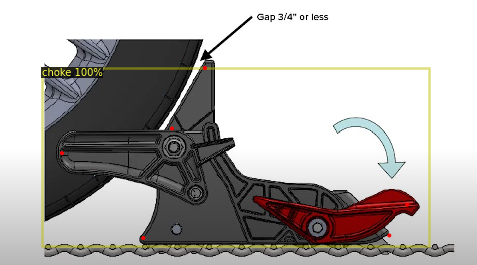

In [29]:
v = Visualizer(im[:, :, ::-1],metadata=model_metadata,scale=0.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [30]:
!cp -r '/content/output' '/content/drive/MyDrive/Keypoint_detection'

In [32]:
!cp -r '/content/Dataset' '/content/drive/MyDrive/Keypoint_detection'